# Космический корабль "Титаник"
Предсказать, какие пассажиры будут перевезены в альтернативное измерение
![Космичекий корабль](dBkH_qdZu6U.jpg)

## Описание набора данных
В этом соревновании задача состоит в том, чтобы предсказать, был ли пассажир перенесен в альтернативное измерение во время столкновения космического корабля "Титаник" с пространственно-временной аномалией. Чтобы помочь вам сделать эти прогнозы, вам предоставляется набор личных записей, восстановленных из поврежденной компьютерной системы корабля.




### Описания файлов и данных

**train.csv** - Личные записи примерно двух третей (8700) пассажиров, которые будут использоваться в качестве обучающих данных.

1. **PassengerId** - Уникальный идентификатор для каждого пассажира. Каждый идентификатор имеет форму gggg_pp, где gggg указывает группу, с которой путешествует пассажир, а pp - их номер в группе. Люди в группе часто являются членами семьи, но не всегда.
2. **HomePlanet** - планета, с которой отбыл пассажир, обычно планета его постоянного проживания.
3. **CryoSleep** - Указывает, решил ли пассажир погрузиться в анабиоз на время рейса. Пассажиры, находящиеся в криосне, заперты в своих каютах.
4. **Cabin** - номер каюты, в которой находится пассажир. Принимает форму deck/num/side, где side может быть либо P для левого, либо S для правого борта.
5. **Destination** - планета, на которую пассажир будет высаживаться.
6. **Age** - возраст пассажира.
7. **VIP** - Оплатил ли пассажир специальное VIP-обслуживание во время рейса.
8. **RoomService**, Фудкорт, торговый центр, спа-салон, VRDeck - сумма, которую пассажир заплатил за каждое из многочисленных роскошных удобств космического корабля "Титаник".
9. **Name** - имя и фамилия пассажира.
10. **Transported** - Был ли пассажир перевезен в другое измерение. Это цель, столбец, который вы пытаетесь предсказать.


**test.csv** - Личные записи оставшейся трети (~4300) пассажиров, которые будут использоваться в качестве тестовых данных. Ваша задача - спрогнозировать стоимость перевозимого груза для пассажиров из этого набора.

**sample_submission.csv** - файл для отправки в правильном формате.
1. PassengerId - идентификатор каждого пассажира в тестовом наборе.
2. Транспортируемый - цель. Для каждого пассажира спрогнозируйте либо истинное, либо ложное значение.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [3]:
train_df = pd.read_csv(f'train.csv')
test_df = pd.read_csv(f'test.csv')

In [4]:
train_df.shape, test_df.shape

((8693, 14), (4277, 13))

In [5]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


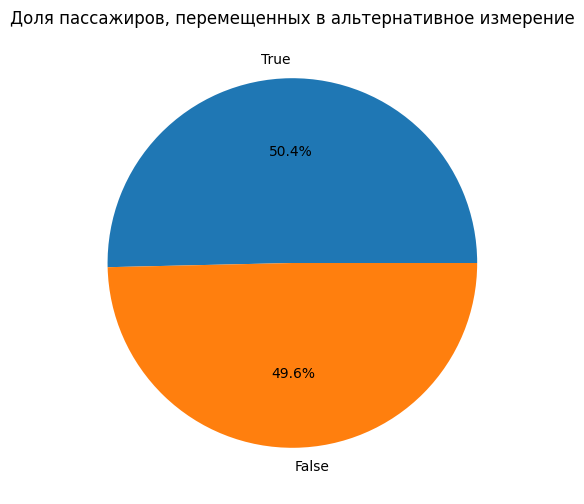

In [6]:
transported_counts = train_df['Transported'].value_counts()
labels = transported_counts.index
values = transported_counts.values

plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title('Доля пассажиров, перемещенных в альтернативное измерение')
plt.show()

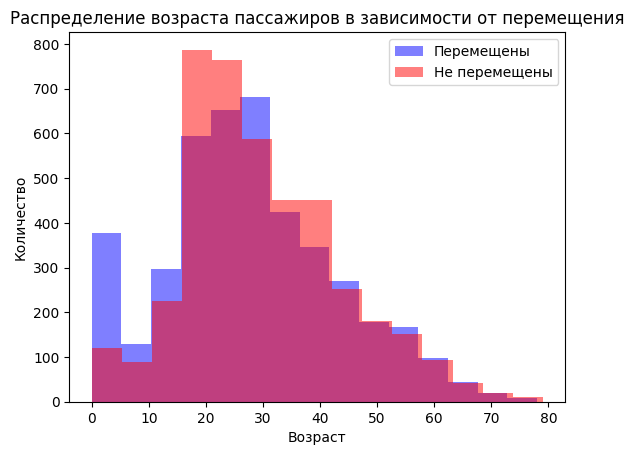

In [7]:

transported_age = train_df[train_df['Transported'] == True]['Age']
not_transported_age = train_df[train_df['Transported'] == False]['Age']

plt.hist(transported_age, bins=15, color='blue', alpha=0.5, label='Перемещены')
plt.hist(not_transported_age, bins=15, color='red', alpha=0.5, label='Не перемещены')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение возраста пассажиров в зависимости от перемещения')
plt.legend()
plt.show()

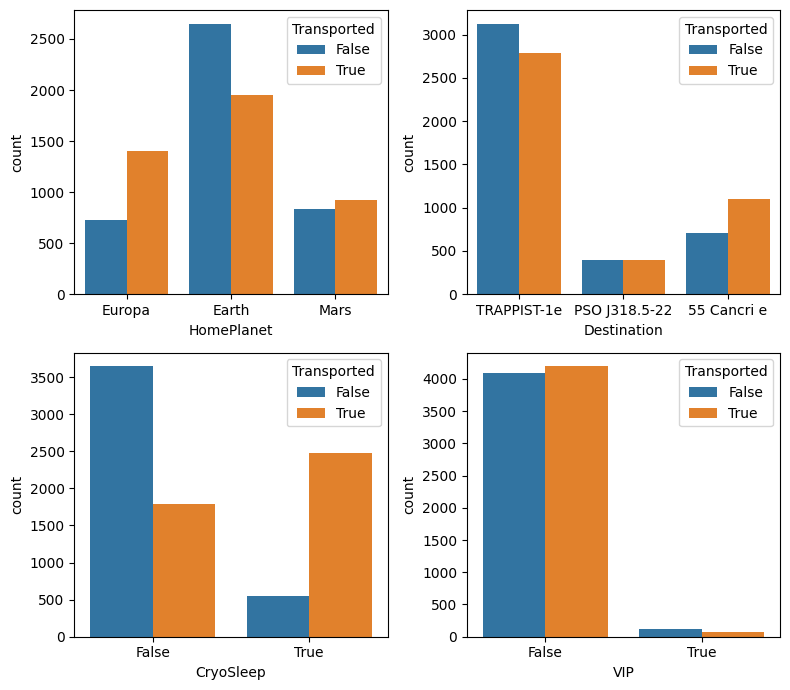

In [8]:
fig = plt.figure(figsize=[8,7])

for i, var_name in enumerate(['HomePlanet', 'Destination', 'CryoSleep', 'VIP']):
    ax = fig.add_subplot(2, 2, i+1)
    sns.countplot(data = train_df, x = var_name, hue = 'Transported', axes=ax)

fig.tight_layout()
plt.show()

In [9]:
train_df.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)
test_df.drop(['Name', 'Cabin'], axis=1, inplace=True)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(4)
memory usage: 687.8+ KB


In [11]:
train_df.isna().sum()

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

In [12]:
# train_df = train_df.fillna(method='ffill') 
# test_df = test_df.fillna(method='ffill')

# train_df = train_df.fillna(train_df.mean())
# test_df = test_df.fillna(test_df.mean())

# train_df = train_df.fillna(value=0)
# test_df = test_df.fillna(value=0)

train_df = train_df.fillna(method='bfill')
test_df = test_df.fillna(method='bfill')

In [13]:
train_df.isna().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

In [14]:
columns = ['HomePlanet',	'CryoSleep',	'Destination']

le = preprocessing.LabelEncoder()


In [15]:
for col in columns:
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

In [16]:
X = train_df.drop(['Transported'], axis=1)
y = train_df.Transported

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3)

Используем для решения задачи классификации модели, которые проходили на парах

In [18]:
tree = DecisionTreeClassifier(max_depth=5, max_features=3, random_state=1)
tree_model = tree.fit(X_train, y_train)
tree_y_pred = tree_model.predict(X_valid)
    
accuracy = accuracy_score(y_valid, tree_y_pred) #
precision = precision_score(y_valid, tree_y_pred)
recall = recall_score(y_valid, tree_y_pred)

print(f'DecisionTreeClassifier\n')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')


DecisionTreeClassifier

Accuracy: 0.74
Precision: 0.76
Recall: 0.71


In [19]:
lr = LogisticRegression(random_state=0)
lr_model = lr.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_valid)
    
accuracy = accuracy_score(y_valid, lr_y_pred)
precision = precision_score(y_valid, lr_y_pred)
recall = recall_score(y_valid, lr_y_pred)

print(f'LogisticRegression\n')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

LogisticRegression

Accuracy: 0.77
Precision: 0.77
Recall: 0.77


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
knn = KNeighborsClassifier(n_neighbors=15)
knn_model = knn.fit(X_train, y_train)
knn_y_pred = knn_model.predict(X_valid)
    
accuracy = accuracy_score(y_valid, knn_y_pred)
precision = precision_score(y_valid, knn_y_pred)
recall = recall_score(y_valid, knn_y_pred)

print(f'KNN\n')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

KNN

Accuracy: 0.78
Precision: 0.76
Recall: 0.81


In [21]:
rf = RandomForestClassifier(n_estimators=200, max_depth=6, max_features=3, random_state=1)
rf_model = rf.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_valid)
    
accuracy = accuracy_score(y_valid, rf_y_pred)
precision = precision_score(y_valid, rf_y_pred)
recall = recall_score(y_valid, rf_y_pred)

print(f'RandomForestClassifier\n')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

RandomForestClassifier

Accuracy: 0.78
Precision: 0.78
Recall: 0.79


Самые удачные метрики у Дерева Решений

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

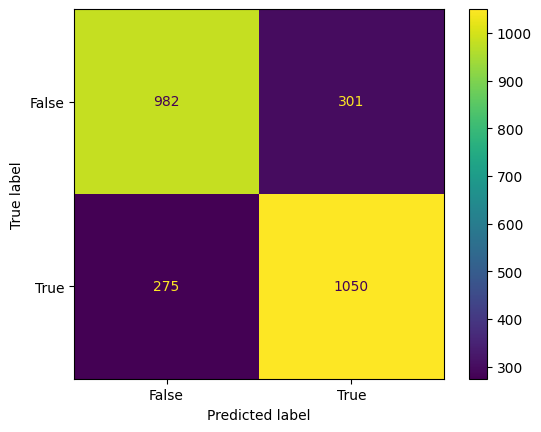

In [23]:
cm = confusion_matrix(y_valid, rf_y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot();

## Оформление решения для Kaggle

In [24]:
sample_submission = pd.read_csv('sample_submission.csv')

In [25]:
sample_submission.head(2)

,PassengerId,Transported
0,0013_01,False
1,0018_01,False


In [26]:
test_df.head(2)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0013_01,0,1,2,27.0,False,0.0,0.0,0.0,0.0,0.0
1,0018_01,0,0,2,19.0,False,0.0,9.0,0.0,2823.0,0.0


In [27]:
test_id = test_df['PassengerId']
test_df.drop('PassengerId', axis = 1, inplace=True)

In [28]:
y_pred_test = rf_model.predict(test_df)

submission_df = pd.DataFrame({'PassengerId': test_id, 'Transported': y_pred_test,})
submission_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [29]:
submission_df.to_csv('submission.csv', index= False)

Итоговый счёт:
![Счёт](img.png)